# Case Study On Object Detection

### Importing Important Libraries

In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

### Used YOLO

You only look once (YOLO) is a state-of-the-art, real-time object detection system.<br>
On a Pascal Titan X it processes images at 30 FPS and has a mAP of 57.9% on COCO test-dev.

### How It Works

Prior detection systems repurpose classifiers or localizers to perform detection. They apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections.

We use a totally different approach. We apply a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.

Our model has several advantages over classifier-based systems. <br>
It looks at the whole image at test time so its predictions are informed by global context in the image. <br>
It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN. See our paper for more details on the full system.

In [7]:
# here we have used YOLO weights
# for image library we have used COCO image library

config_path='C:/Users/RAVI KRISHNA/python/pytorch_objectdetecttrack-master/config/yolov3.cfg'
weights_path='C:/Users/RAVI KRISHNA/python/pytorch_objectdetecttrack-master/config/yolov3.weights'
class_path='C:/Users/RAVI KRISHNA/python/pytorch_objectdetecttrack-master/config/coco.names'


In [13]:
#setting initials

img_size=416
conf_thres=0.8
nms_thres=0.4

### Loading Darknet from YOLO

In [8]:
# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [17]:
# method for detection of image

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

OUTPUT IMAGE
Inference Time: 0:00:00.760592


<Figure size 432x288 with 0 Axes>

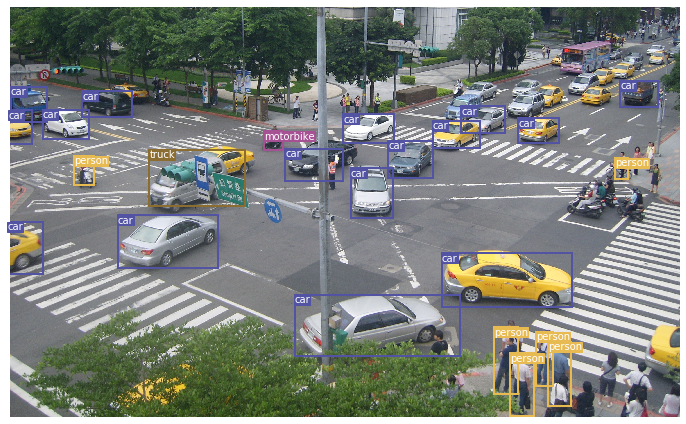

Wall time: 4.75 s


In [18]:
%%time
# load image and get detections

img_path = "images/Intersection-Counts.jpg"# here user can give path of input pic
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print("OUTPUT IMAGE:)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

                                                ---xxx---